In [1]:
import json
import random
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
intents_json = json.loads(open('/kaggle/input/intents/intents.json').read())
intents = pd.DataFrame(intents_json['intents'])

In [3]:
intents.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Hello, Good day]","[Hello, Good to see you again, Hi there, how c..."
1,farewell,"[Bye, See you later, Goodbye, Get lost, Till n...","[See you!, Have a nice day, Bye! Come back aga..."
2,thanks,"[Thanks, Thank you, That's helpful, Awesome, t...","[Happy to help!, Any time!, My pleasure]"
3,options,"[How you could help me?, What you can do?, Wha...",[Answering your queries]
4,identity,"[Who are you?, what are you?]",[I am an intent-based chatbot]


In [4]:
class Pipeline:
    
    def __init__(self, intents : pd.DataFrame) -> None:       
        self.intents = intents

        self.tag_list = [] # Dump To Data
        self.tokenizer = Tokenizer() # Dump To Data

        self.model = Sequential()   
    
    # Data Analysis
    def __dataset_process__(self) -> list:
        '''
        1. Split Each Word From Patterns
        2. Return A List Of Patterns With Their Respective Tags And Responses
        '''
        tags = []
        patterns = []
        responses = []

        for i in range(len(self.intents)):
            patterns.extend(self.intents.iloc[i]['patterns'])

            for word in self.intents.iloc[i]['patterns']:
                tags.append(self.intents.iloc[i]['tag'])
                responses.append(self.intents.iloc[i]['responses'])
        
        return [patterns, tags, responses]
    
    def __gen_dummies__(self) -> None:
        '''
        1. Create New DataFrame From The Processed Dataset
        2. Create Dummy Variables For Tags
        '''
        [self.patterns, self.tags, self.responses] = self.__dataset_process__()
        self.intents_ref = pd.DataFrame({'tag' : self.tags,
                        'pattern' : self.patterns,
                        'respones' :self.responses})
        
        self.tag_dummy = pd.get_dummies(self.intents_ref['tag'])

        self.tag_list = self.tag_dummy.columns.values

    # Text Preprocessing And Generating Training Data
    def __gen_train__(self) -> None:
        '''
        Generate Training Data
        '''
        self.pattern_vector = self.intents_ref['pattern'].values
        self.tag_train = self.tag_dummy.values

        self.pattern_train = self.tokenizer.fit_on_texts(self.pattern_vector)
        self.pattern_train = self.tokenizer.texts_to_matrix(self.pattern_vector)
    
    # Create Model
    def __create_model__(self) -> None:
        '''
        Uses Keras API And Creates A Deep Layer Model
        '''

        self.model.add(layers.Dense(units= 200, activation= 'relu'))
        self.model.add(layers.Dropout(0.5))

        self.model.add(layers.Dense(units= 100, activation= 'relu'))
        self.model.add(layers.Dropout(0.5))

        self.model.add(layers.Dense(units= self.tag_train.shape[1], activation= 'softmax'))

        self.model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])
    
    # Pipeline transform
    def fit(self, verbose : int = 1) -> Sequential:
        '''
        1. Loads The Data
        2. Transforms The Data
        3. Generates Training Data
        4. Fits Data To Model
        '''
        self.__gen_dummies__()
        self.__gen_train__()

        self.__create_model__()

        self.model.fit(x= self.pattern_train, y= self.tag_train, epochs= 200, 
                    batch_size= 32,
                    verbose= verbose)
        
        return self.model

In [5]:
pipeline = Pipeline(intents)

In [6]:
model = pipeline.fit()

Epoch 1/200
2/2 [==============================] - 5s 13ms/step - loss: 2.6183 - accuracy: 0.0909
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6709 - accuracy: 0.0182
Epoch 3/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6254 - accuracy: 0.0364
Epoch 4/200
2/2 [==============================] - 0s 6ms/step - loss: 2.5994 - accuracy: 0.0364
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6048 - accuracy: 0.0545
Epoch 6/200
2/2 [==============================] - 0s 6ms/step - loss: 2.5793 - accuracy: 0.1273
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 2.5589 - accuracy: 0.1273
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.5273 - accuracy: 0.2000
Epoch 9/200
2/2 [==============================] - 0s 6ms/step - loss: 2.5497 - accuracy: 0.1091
Epoch 10/200
2/2 [==============================] - 0s 6ms/step - loss: 2.4985 - accuracy: 0.2364
Epoch 11/200
2/2 [==========

<Axes: >

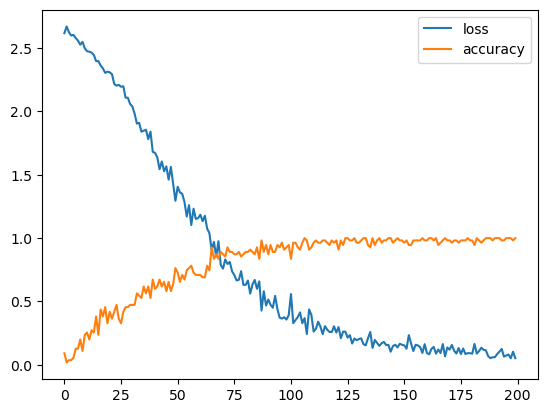

In [7]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [8]:
class ChatBot:
    def __init__(self) -> None:

        self.THRESHOLD = 0.8
        self.AMBIGUITY = 'I Could Not Understand What You Said.'

        # Load Model
        self.model = model

        # Load Pickle Files
        self.tag_list = pipeline.tag_list
        self.tokenizer = pipeline.tokenizer

        # Load Intents As DataFrame
        self.intents = intents

    def __predict__(self, input : str) -> tuple:
        '''
        1. Takes In A User Input
        2. Processes The Input And Converts It To Vector For Model
        3. Generates Model's Predicted Tag As A String
        4. Generates Model's Probability For The Predicted Tag
        '''

        # Convert Input Text To Pandas Series
        input_series = pd.Series([input])

        # Tokenize And Convert Series To nparray
        input_vector = self.tokenizer.texts_to_matrix(input_series)

        # Generate Prediction
        prediction = self.model.predict(input_vector, verbose= 0)

        prediction_index = prediction.argmax(-1)
        prediction_probability = prediction.max()

        # Return Prediction As String
        return (self.tag_list[prediction_index][0], prediction_probability)

    def __response_list__(self, tag : str) -> list[str]:
        '''
        1. Takes In The Model's Predicted Tag As Input
        2. Returns The List Of Responses From Intents DataFrame For The Predicted Tag
        '''

        response_series = self.intents[self.intents['tag'] == tag]['responses']
        
        responses = response_series.values
        return responses[0]

    def __gen_response__(self, response_list : list[str]) -> str:
        '''
        1. Takes In The Generated Response List Of The Predicted Tag
        2. Returns An Element From The List As Reponse
        '''

        response = random.choice(response_list)
        return response
        
    def __tag_threshold__(self, probability : float) -> bool:
        '''
        1. Implement A Probability Threshold On Model's Prediction.
        2. If Prediction's Probability Is More Than Or Equal To The Threshold, The Model Continues With The Predicted Tag.
        3. If Prediction's Probability Is Less Than Threshold, The Model Prints Ambiguity Statement
        '''

        if probability >= self.THRESHOLD:
            return True
        else:
            return False

    def run(self, message : str) -> str:
        
        try:
            (tag_predict, tag_probability) = self.__predict__(message)

            # Check Error Threshold For The Predicted Tag
            if self.__tag_threshold__(tag_probability):
                responses_predict = self.__response_list__(tag_predict)
                response = self.__gen_response__(responses_predict)

                return response  
            else:
                return self.AMBIGUITY
        except Exception as e:
            return str(e)

In [9]:
chatbot = ChatBot()

In [10]:
text = 'Hello'

response = chatbot.run(message= text)
print(f'Model: {response}')

Model: Hi there, how can I help?


In [11]:
text = 'Who Are You?'

response = chatbot.run(message= text)
print(f'Model: {response}')

Model: I am an intent-based chatbot


In [12]:
text = 'Can You Help Me?'

response = chatbot.run(message= text)
print(f'Model: {response}')

Model: Answering your queries


In [13]:
text = 'Random Text'

response = chatbot.run(message= text)
print(f'Model: {response}')

Model: I Could Not Understand What You Said.
